In [ ]:
%cd ./face_module/
!git clone https://github.com/tphlru/pyVHR.git pyVHR2

%cd ./pyVHR2
%pip install .
%cd ..

%pip install -r ../requirements.txt
# %conda install compilers libstdcxx-ng=12
%conda install webrtcvad
# !nvcc --help

In [2]:
import logging

file_log = logging.FileHandler("logfile.log")
console_out = logging.StreamHandler()

logging.basicConfig(
    handlers=(file_log, console_out),
    format="[%(asctime)s | %(levelname)s]: %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    level=logging.INFO,
)

print("logger name:", __name__)
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

# level=logger.INFO / level=logger.DEBUG

logger.info(" >>> ---- Program restarted! ---- <<< ")

import logging

log = logging.getLogger(__name__)

log.info("Hello logging!")

[08/02/2024 10:30:27 | INFO]:  >>> ---- Program restarted! ---- <<< 


logger name: __main__


In [3]:
import os

from pyVHR.extraction.sig_processing import SignalProcessing
from pyVHR.extraction.skin_extraction_methods import SkinExtractionConvexHull, SkinProcessingParams
from pyVHR.extraction.sig_extraction_methods import SignalProcessingParams
from pyVHR.extraction.utils import get_fps, sig_windowing, MotionAnalysis
from pyVHR.BVP.filters import BPfilter, apply_filter
from pyVHR.BVP.methods import cpu_PBV
from pyVHR.BVP.BVP import RGB_sig_to_BVP
from pyVHR.BPM.BPM import BPM_clustering

from helpers_code import vhr_ldmks_list

2024-08-02 10:30:32.283066: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-02 10:30:32.299232: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-02 10:30:32.303966: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-02 10:30:32.316032: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-02 10:30:33.125373: W tensorflow/compiler/tf2

In [30]:
def get_bpm_with_pbv(
    videoFileName,
    cuda=True,
    verb=True if logger.level == logging.DEBUG else False,
    winsize=4,
):

    # Constants
    patch_size = 30
    RGB_LOW_HIGH_TH = (75, 230)
    Skin_LOW_HIGH_TH = (75, 230)
    movement_thrs = [10, 5, 2]  # or [15, 15, 15]

    assert os.path.isfile(videoFileName), "The video file does not exists!"
    sig_processing = SignalProcessing()

    if cuda:
        logger.debug("Using GPU")
        if verb:
            sig_processing.display_cuda_device()
        sig_processing.choose_cuda_device(0)
    target_device = "GPU" if cuda else "CPU"

    # Извлекаем зону кожного покрова (regioregion of interest - ROI)
    # ROI метод: convexhull
    sig_processing.set_skin_extractor(SkinExtractionConvexHull(target_device))

    # ROI подход: patches
    sig_processing.set_landmarks(vhr_ldmks_list)
    sig_processing.set_square_patches_side(float(patch_size))

    # Устанавливаем параметры обработчиков
    SignalProcessingParams.RGB_LOW_TH = RGB_LOW_HIGH_TH[0]
    SignalProcessingParams.RGB_HIGH_TH = RGB_LOW_HIGH_TH[1]
    SkinProcessingParams.RGB_LOW_TH = Skin_LOW_HIGH_TH[0]
    SkinProcessingParams.RGB_HIGH_TH = Skin_LOW_HIGH_TH[1]

    logger.info("Processing Video: " + videoFileName)

    # Ставим 0, чтобы обработать все доступные кадры
    sig_processing.set_total_frames(0) 
    fps = get_fps(videoFileName) # Частота кадров исходного видео

    # Извлекаем patches из видео
    sig = sig_processing.extract_patches(videoFileName, "squares", "mean")

    # Разбиваем на перекрывающиеся временные промежутки по 3 RGB каналам
    windowed_sig, timesES = sig_windowing(sig, winsize, 1, fps)

    logger.debug(f" - No. of windows = {len(windowed_sig)}")
    logger.debug(f" - Window size: (#ROI, #landmarks, #frames) = {windowed_sig[0].shape}")

    # Применяем алгоритмы фильтрации к полученному сигналу
    filtered_windowed_sig = apply_filter(
        windowed_sig,
        BPfilter,
        fps=fps,
        params={
            "minHz": 0.6,  # Наименьшее значение пульса в герцах
            "maxHz": 4,  # Наибольшее значение пульса в герцах
            "fps": "adaptive",
            "order": 6,
        },
    )

    logger.debug(" - Pre-filter applied: BPfilter")

    # Извлекаем линию (информация о движении) пульса объёма крови
    logger.info("BVP extraction with 'cpu_PBV' method ...")

    bvps_win_m = RGB_sig_to_BVP(
        filtered_windowed_sig,
        fps,
        device_type="cpu",
        method=cpu_PBV,
        params={},
    )

    # Теперь анализируем количество ударов в минуту (BPM) по полученной линии пульса
    logger.info("BPM estimation...")

    # - Используем landmarks от mediapipe для компенсации движения лица
    ma = MotionAnalysis(sig_processing, winsize, fps) 
    bpmES = BPM_clustering(
        ma,
        bvps_win_m,
        fps,
        winsize,
        movement_thrs=movement_thrs,
        opt_factor=0.5,
    )
    # ГОТОВО!
    logger.info("DONE!")

    return bvps_win_m, timesES, bpmES


bvps, timesES, bpmES = get_bpm_with_pbv("./test_vids/zlata83.mp4")

[08/02/2024 11:03:50 | INFO]: Processing Video: ./test_vids/zlata83.mp4
I0000 00:00:1722585830.511747    8163 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1722585830.513716   32280 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.1.4), renderer: zink Vulkan 1.3(NVIDIA GeForce GTX 1060 6GB (NVIDIA_PROPRIETARY))
W0000 00:00:1722585830.516563   32276 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1722585830.524574   32272 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/home/timur/miniforge3/envs/ti/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn

MOTION_X_FILT applied!
MOTION_Y_FILT applied!
MOTION_X_FILT applied!
MOTION_Y_FILT applied!
MOTION_Z_FILT applied!
MOTION_X_FILT applied!
MOTION_Y_FILT applied!
MOTION_Z_FILT applied!
MOTION_Y_FILT applied!
MOTION_X_FILT applied!
MOTION_Y_FILT applied!
MOTION_X_FILT applied!
MOTION_Y_FILT applied!
MOTION_X_FILT applied!
MOTION_Y_FILT applied!
MOTION_Z_FILT applied!
MOTION_X_FILT applied!
MOTION_Y_FILT applied!
MOTION_Z_FILT applied!
MOTION_Y_FILT applied!
MOTION_Y_FILT applied!
MOTION_Y_FILT applied!
MOTION_X_FILT applied!
MOTION_Y_FILT applied!


[08/02/2024 11:04:03 | INFO]: DONE!


MOTION_X_FILT applied!
MOTION_Y_FILT applied!


In [ ]:
# cpu_ICA vs cpu_PBV = cpu_PBV
# cpu_PBV vs cpu_CHROM = cpu_PBV
# cpu_PBV vs cpu_OMIT = cpu_PBV

In [5]:
%matplotlib inline
import os
import matplotlib
from matplotlib import cm
from matplotlib import pyplot as plt
from matplotlib.patches import Circle, Wedge, Rectangle
import numpy as np


def gauge(labels=["SUPER", "OK", "NORMAL", "BAD", "TOO BAD"],
          colors=['red','LightCoral','LightSkyBlue','LightGreen','ForestGreen'],
          arrow="",
          title="",
          fname=False):

    def degree_range(n):
        start = np.linspace(0,180,n+1, endpoint=True)[0:-1]
        end = np.linspace(0,180,n+1, endpoint=True)[1::]
        mid_points = start + ((end-start)/2.)
        return np.c_[start, end], mid_points

    N = len(labels)
    fig, ax = plt.subplots(figsize=(2, 2))
    fig.subplots_adjust(0,0,2,1)
    ang_range, mid_points = degree_range(N)
    labels = labels[::-1]
    patches = []
    for ang, c in zip(ang_range, colors):
        patches.append(Wedge((0.,0.), .4,*ang, facecolor='w', lw=2 ))
        patches.append(Wedge((0.,0.), .4,*ang, width=0.2, facecolor=c, lw=2, alpha=0.5,))
    [ax.add_patch(p) for p in patches]
    for mid, lab in zip(mid_points, labels):
        ax.text(0.42 * np.cos(np.radians(mid)), 0.42 * np.sin(np.radians(mid)), lab, \
            horizontalalignment='center', verticalalignment='center', fontsize=14, \
            fontweight='bold', rotation = np.degrees(np.radians(mid) * np.pi / np.pi - np.radians(90)))
    r = Rectangle((-0.4,-0.1),0.8,0.1, facecolor='w', lw=2)
    ax.add_patch(r)
    ax.text(0, -0.1, title, horizontalalignment='center', \
         verticalalignment='center', fontsize=18 )
    pos = mid_points[abs(arrow - N)]
    ax.arrow(0, 0, 0.225 * np.cos(np.radians(pos)), 0.225 * np.sin(np.radians(pos)), \
                 width=0.04, head_width=0.09, head_length=0.1, fc='k', ec='k')
    ax.add_patch(Circle((0, 0), radius=0.02, facecolor='k'))
    ax.add_patch(Circle((0, 0), radius=0.01, facecolor='w', zorder=11))
    ax.set_frame_on(False)
    ax.axes.set_xticks([])
    ax.axes.set_yticks([])
    ax.axis('equal')

In [6]:
def get_largest_serially(source_list, n):
    n+=1
    indices = {x: y for x, y in zip(source_list, range(0, len(source_list)))}
    top = sorted(source_list, reverse=True)[:n]
    res = [source_list[i] for i in sorted({indices[i] for i in top})]
    # print(len(res))
    return res

# Get 5 largest values
# Correct: 34, 45, 23, 56, 89

# get_largest_serially([34, 12, 45, 7, 23, 56, 89, 1, 2, 3, 4, 5, 6, 7, 8, 9], 5)

In [7]:
def get_midpoints(seq):
    win_size = 2
    wins = []
    for i in range(len(seq) - win_size + 1):
        wins.append(seq[i: i + win_size])
    return [(f+s) / 2 for f, s in wins]

In [8]:
def get_plot_tops(dividing_line, seq):
    win_size = 2
    tops = []
    for n, (i, v) in enumerate(zip(range(len(dividing_line) - win_size + 2), seq)):
        if v > (max(list(dividing_line[i: i + win_size]))):
            tops.append([n, v])
    return tops

In [9]:
# Весьма спорное решение, может можно придумать что-нибудь по-лучше
def get_trend(seq):
    list_of_index = list(range(len(seq)))
    result = np.polyfit(list_of_index, list(seq), 1)
    slope = float(result[-2])

    if slope < 0.5:
        return -1 # negative trend
    elif slope > 1.1:
        return 1 # positive trend
    else:
        return 0 # no trend


In [10]:
def add_offset(data, offset=10):
    return [i+offset for i in data]

Trend: Uptrend
Median value: 71.36523818969727
Tops (9) median of the largest 3: 83.39656448364258


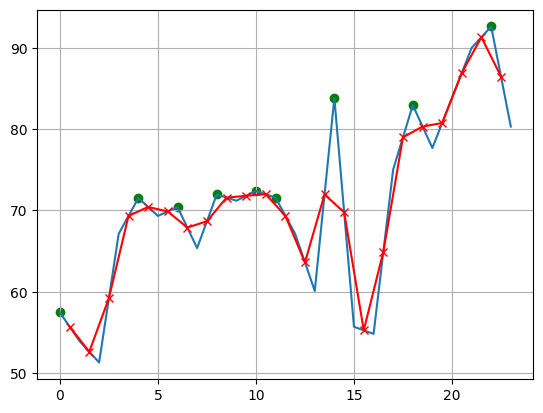

In [35]:
import matplotlib.pyplot as plt
import statistics
import heapq

x = add_offset(list(bpmES.tolist()), 10)

base_mean = statistics.median(x)

plt.plot(x)
midpoints = get_midpoints(x)

tops = get_plot_tops(get_midpoints(x), x)
tops_values = [i[1] for i in tops]

trend = get_trend(tops_values)
print("Trend:", {0: "No trend", 1: "Uptrend", -1: "Downtrend"}[trend])

print("Median value:", base_mean)


highs_med = statistics.median(get_largest_serially(tops_values, 3))
print(f"Tops ({len(tops_values)}) median of the largest 3:", highs_med)

plt.plot(list([(i+1 + i) / 2 for i in range(len(midpoints))]), midpoints, marker="x", color='r')
plt.scatter([i[0] for i in tops], tops_values, marker="o", color='g')
plt.grid(True)
plt.show()

In [1]:
points = 0
points_mather = {-1: 1, 0: 2, 1: 3, 2: 4, 3: 5}

if (highs_med - base_mean > 12 and base_mean > 80) or max(midpoints) - min(midpoints) > 12:
    points += 1
    print("+++ Пульс нестабилен!")

if highs_med > 90:
    points += 1
    print("+++ Высокий фон пульса!")

if max(tops_values) > 102:
    points += 1
    print(f"+++ Найден высокий пик {max(tops_values)}!")

if trend == 1:
    points += 1
    print("+++ Восходящий тренд! Пульс увеличивается - возможно, человек начинает волноваться.")

elif trend == -1:
    points -= 1
    print("--- Нисходящий тренд! Пульс уменьшается - возможно, человек просто запыхался.")

else:
    print("--- Тренд изменений отсутствует. Эта метрика не учитывается. ---")

gauge(title = "PULSE SCORE", arrow = points_mather[points])

NameError: name 'highs_med' is not defined

In [10]:
# pyVHR.plot.visualize.visualize_BVPs(bvps, len(bvps)-1)